In [1]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_validate, GroupKFold
import statsmodels.api as sm
from exp_version import get_hp_from_version_code


from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo_v1
from M1_util_train_test import load_model, test
import linear_reg
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir

plt.rcParams.update({"font.size":12})

In [2]:
data_version = '1571'

model_type = 'AE'
sampling = 's'

zoomlevel = 'zoom15'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']


# Load Model Embeddings

In [3]:
with open(proj_dir+"latent_space/2023-06-30T01-32-58_sae_3_0.9_ep88.pkl", "rb") as f:
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)
    sup_true_list = pkl.load(f)
    sup_list = pkl.load(f)

In [4]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
#     aggregate_embeddings.append(np.mean(sup_list[ct == i], axis=0))
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

x = aggregate_embeddings

x = x.reshape(x.shape[0],-1)

# Load Trip Behavior

In [5]:
file = "MyDailyTravel/origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, data_version)
y_ct = df_pivot['geoid'].to_list()
y = df_pivot[variable_names].to_numpy()[:,:4]

groups = df_pivot['train_test']
group_split = GroupKFold(n_splits=5)

In [6]:
if len(x) != len(y):
    x_mask = [True if c in y_ct else False for c in unique_ct]
    x = x[x_mask,:]
    unique_ct = list(np.array(unique_ct)[x_mask])
    y_mask = [True if c in unique_ct else False for c in y_ct]
    y = y[y_mask,:]
    y_ct = list(np.array(y_ct)[y_mask])

x = x[[y_ct.index(val) for val in unique_ct],:]
unique_ct = list(np.array(unique_ct)[np.array([y_ct.index(val) for val in unique_ct])])
for xc,yc in zip(unique_ct, y_ct):
    assert xc == yc

# 1. Linear Regression

### 1.1 Auto Share

In [7]:
y_index = 1

In [8]:
# Lasso
for a in (1e-3)*np.array([1,2,3,4,5]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.405e-01, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.843e-01, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-03 	 Train score: 0.7920 	 Cross val score: 0.6268 	 Nonzero coef: 291


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e-01, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.298e-02, tolerance: 6.596e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 2.00e-03 	 Train score: 0.7196 	 Cross val score: 0.6440 	 Nonzero coef: 116


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.380e-03, tolerance: 6.768e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e-02, tolerance: 7.111e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 3.00e-03 	 Train score: 0.6964 	 Cross val score: 0.6430 	 Nonzero coef: 76
Parameter: 4.00e-03 	 Train score: 0.6842 	 Cross val score: 0.6429 	 Nonzero coef: 58
Parameter: 5.00e-03 	 Train score: 0.6762 	 Cross val score: 0.6407 	 Nonzero coef: 51


### 1.2 PT

In [9]:
y_index=3

In [10]:
# Lasso
for a in (1e-3)*np.array([1,2,3,4,5]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-02, tolerance: 1.168e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-02, tolerance: 1.130e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-03 	 Train score: 0.5976 	 Cross val score: 0.4791 	 Nonzero coef: 114
Parameter: 2.00e-03 	 Train score: 0.5451 	 Cross val score: 0.4820 	 Nonzero coef: 47
Parameter: 3.00e-03 	 Train score: 0.5248 	 Cross val score: 0.4786 	 Nonzero coef: 33
Parameter: 4.00e-03 	 Train score: 0.5157 	 Cross val score: 0.4766 	 Nonzero coef: 27
Parameter: 5.00e-03 	 Train score: 0.5090 	 Cross val score: 0.4745 	 Nonzero coef: 23


### 1.3 Active

In [11]:
y_index=0

In [12]:
# Lasso
for a in (1e-3)*np.array([1,2,3,4,5]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e-01, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e-01, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 1.00e-03 	 Train score: 0.6994 	 Cross val score: 0.5000 	 Nonzero coef: 225


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.169e-02, tolerance: 3.383e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.941e-03, tolerance: 3.240e-03
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Parameter: 2.00e-03 	 Train score: 0.6089 	 Cross val score: 0.5244 	 Nonzero coef: 80
Parameter: 3.00e-03 	 Train score: 0.5831 	 Cross val score: 0.5312 	 Nonzero coef: 51
Parameter: 4.00e-03 	 Train score: 0.5711 	 Cross val score: 0.5307 	 Nonzero coef: 40
Parameter: 5.00e-03 	 Train score: 0.5629 	 Cross val score: 0.5282 	 Nonzero coef: 33


# 2. MNL for Mode Share

In [8]:
results = {0:{}, 1:{}, 2:{}, 3:{}, 4:{}}


In [22]:
from util_aggregate_models import mnl_torch

# dataloader and model definition

lr_list = [1e-5]
wd_list = [1e+2]

for i in range(1,5):
    
    train_filter = groups != i
    test_filter = groups == i
    x_train = x[train_filter]
    y_train = y[train_filter]
    x_test = x[test_filter]
    y_test = y[test_filter]
    sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
    sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)
    
    trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

    testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    ret_dict = mnl_torch(trainloader, testloader, x_train.shape[-1], sst_train, sst_test, lr_list=lr_list, wd_list=wd_list,
                        save_models=False)
    
    results[i].update(ret_dict)    

[lr: 1.00e-05, wd: 1.00e+02]
Early stopping at epoch 3370
[epoch: 3360] Train KL loss: 0.088 Train R2 score: 0.764 0.792 0.190 0.687 
[epoch: 3360] Test KL loss: 0.140 Test R2 score: 0.494 0.621 -0.052 0.408 

[lr: 1.00e-05, wd: 1.00e+02]
Early stopping at epoch 3380
[epoch: 3370] Train KL loss: 0.082 Train R2 score: 0.783 0.816 0.322 0.704 
[epoch: 3370] Test KL loss: 0.124 Test R2 score: 0.478 0.624 -0.056 0.451 

[lr: 1.00e-05, wd: 1.00e+02]
[epoch: 3980] Train KL loss: 0.086 Train R2 score: 0.761 0.803 0.262 0.707 
[epoch: 3980] Test KL loss: 0.115 Test R2 score: 0.627 0.693 -0.131 0.454 

[lr: 1.00e-05, wd: 1.00e+02]
[epoch: 3990] Train KL loss: 0.075 Train R2 score: 0.808 0.839 0.319 0.767 
[epoch: 3990] Test KL loss: 0.143 Test R2 score: 0.417 0.616 -0.066 0.481 



In [23]:
df = []

lr_list = [1e-5]
wd_list = [1e+4, 1e+3, 100, 10, 1]

for (lr, wd) in itertools.product(lr_list, wd_list):

    new = []
    
    for i in range(5):
        new2 = []
        for k,v in results[i][(lr,wd)].items():
            if k != 'train_loss' and k != 'test_loss':
                new2.append(results[i][(lr,wd)][k]) 
        new.append(new2)
        
    new = np.array(new) 
    
    df.append([lr] + [wd] + list(np.mean(new, axis=0)))


pd.DataFrame(np.array(df), columns = ['learning_rate','weight_decay','train_kl_loss','test_kl_loss','train_r2_auto','train_r2_active','train_r2_pt',
                                     'test_r2_auto','test_r2_active','test_r2_pt']).sort_values(by='test_kl_loss')

,learning_rate,weight_decay,train_kl_loss,test_kl_loss,train_r2_auto,train_r2_active,train_r2_pt,test_r2_auto,test_r2_active,test_r2_pt
1,0.00001,1000.0,0.111378,0.127947,0.704159,0.627169,0.568777,0.642882,0.523653,0.475909
0,0.00001,10000.0,0.123745,0.129049,0.658470,0.557780,0.516936,0.638284,0.529239,0.487337
2,0.00001,100.0,0.084392,0.130617,0.807652,0.777548,0.708027,0.636118,0.499475,0.454408
3,0.00001,10.0,0.083860,0.131610,0.803154,0.771443,0.738307,0.633428,0.501606,0.439067
4,0.00001,1.0,0.080918,0.132927,0.811473,0.785807,0.729977,0.632071,0.486227,0.442502


(0.0, 0.2)

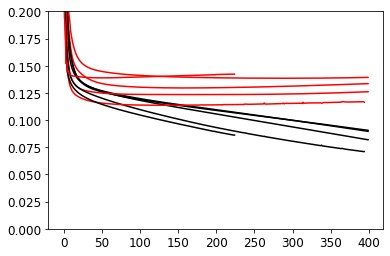

In [12]:
lr = 1e-5
wd = 10
for i in range(5):
        plt.plot(results[i][(lr, wd)]['train_loss'], c='black')
        plt.plot(results[i][(lr, wd)]['test_loss'], c='red')
plt.ylim([0,0.2])

In [16]:
df = []

for (lr, wd) in itertools.product(lr_list, wd_list):

    new = []
    
    for i in range(5):
        new2 = []
        for k,v in results[i][(lr,wd)].items():
            new2.append(results[i][(lr,wd)][k]) 
        new.append(new2)
        
    new = np.array(new) 
    
    df.append([lr] + [wd] + list(np.mean(new, axis=0)))


pd.DataFrame(np.array(df), columns = ['learning_rate','weight_decay','train_kl_loss','test_kl_loss','train_r2_auto','train_r2_active','train_r2_pt',
                                     'test_r2_auto','test_r2_active','test_r2_pt']).sort_values(by='test_kl_loss')

,learning_rate,weight_decay,train_kl_loss,test_kl_loss,train_r2_auto,train_r2_active,train_r2_pt,test_r2_auto,test_r2_active,test_r2_pt
1,0.0001,0.0100,0.109315,0.138404,0.712724,0.634471,0.593640,0.597671,0.488158,0.431714
3,0.0001,0.0001,0.114054,0.141006,0.703157,0.622583,0.564238,0.624304,0.488380,0.423158
2,0.0001,0.0010,0.120864,0.146180,0.685106,0.603797,0.546201,0.588821,0.472254,0.408024
0,0.0001,0.1000,0.137119,0.146438,0.626710,0.498668,0.461746,0.585129,0.409555,0.374959
6,0.0002,0.0010,0.149035,0.158456,0.590239,0.478582,0.242024,0.547520,0.362860,0.280133
5,0.0002,0.0100,0.178673,0.187521,0.534564,0.170244,0.092533,0.488444,0.388526,-0.523059
7,0.0002,0.0001,0.150342,0.200315,0.615386,0.522976,0.361235,0.530836,0.220243,-0.263225
4,0.0002,0.1000,0.168119,0.212490,0.563597,0.472240,0.124115,0.432032,0.269858,-0.764150
